In [1]:
import PIL
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm
import logging

import matplotlib.image as mpimg
import json

from skimage.color import rgb2gray
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

import torch
import time
import copy
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as func
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor,Resize

from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score,accuracy_score,recall_score,classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_data(foldername = 'dataset/', train_size = 310, test_size = 110):

    fileList = []
    for dirname, _, filenames in os.walk(foldername):
#         print(dirname)
#         print(filenames)
        for filename in filenames:
            if filename =='666.jpg' or filename == '11702.jpg':
                continue
            fileList.append(os.path.join(dirname, filename))

    
    classList = []

    for i in range(len(fileList)):
        if 'hunzhuo' in fileList[i]:
            classList.append('hunzhuo')
        else:
            classList.append('tuoli')

    df = pd.DataFrame({'filepath':fileList,'label':classList})  

    trainDf,testDf, trainy,testy = train_test_split(df, df.label, train_size = train_size, test_size =test_size)

    return trainDf, testDf

In [3]:
trainDf, testDf = load_data(train_size = 310, test_size = 110)

In [4]:
print(trainDf)

                                              filepath    label
319                          dataset/tuoli/tuoli98.jpg    tuoli
49                       dataset/hunzhuo/hunzhuo49.jpg  hunzhuo
90                       dataset/hunzhuo/hunzhuo90.jpg  hunzhuo
237                          dataset/tuoli/tuoli16.jpg    tuoli
289                          dataset/tuoli/tuoli68.jpg    tuoli
220  dataset/hunzhuo/.ipynb_checkpoints/hunzhuo0-ch...  hunzhuo
242                          dataset/tuoli/tuoli21.jpg    tuoli
9                         dataset/hunzhuo/hunzhuo9.jpg  hunzhuo
145                     dataset/hunzhuo/hunzhuo145.jpg  hunzhuo
178                     dataset/hunzhuo/hunzhuo178.jpg  hunzhuo
83                       dataset/hunzhuo/hunzhuo83.jpg  hunzhuo
24                       dataset/hunzhuo/hunzhuo24.jpg  hunzhuo
116                     dataset/hunzhuo/hunzhuo116.jpg  hunzhuo
216                     dataset/hunzhuo/hunzhuo216.jpg  hunzhuo
39                       dataset/hunzhuo

In [5]:
def getFeat(net, imgList):

    net.eval()
    featList = []

    with torch.no_grad():
        for i in range(len(imgList)):
            feat = net.getFeatures(imgList[i])
            featList.append(feat.squeeze(0).detach().cpu().numpy())

    return np.array(featList)

In [6]:
def getCDDistribution(net,imgList, labelList ):

    uniqueClasses = [0,1]

    NUM_COLORS = 2

    # featList = []

    # for i in range(len(imgList)):
    #     feat = net.getFeatures(imgList[i])
    #     featList.append(feat.squeeze(0).detach().cpu().numpy())


    get_color = plt.get_cmap('viridis')

    colorMap = {}
    for i in range(len(uniqueClasses)):
        colorMap[uniqueClasses[i]] = get_color(i/NUM_COLORS)
    
    support = getFeat(net, imgList)
    X = support

    print(X.shape)

    # scaler = StandardScaler()
    # X = scaler.fit_transform(support)

    pca = PCA(n_components=2)
    pcaX = pca.fit_transform(X=X)
    varExplained = np.sum(pca.explained_variance_ratio_[:2])
    print(f"Variance Explained : {varExplained}")

    colors = [colorMap[int(x)] for x in labelList]
    for i in range(len(uniqueClasses)):
      index = np.array(labelList) == int(uniqueClasses[i])
      plt.scatter(pcaX[index,0], pcaX[index,1], color=colorMap[int(uniqueClasses[i])], label =int(uniqueClasses[i]))
    plt.legend()

    plt.show()

In [7]:
def getSupport(net, dataloader):

    supports = []
    labels = []

    with torch.no_grad():

        net.eval()

        for data in dataloader:
            x,y = data
            x = x.to('cuda')
            feat = net.getFeatures(x)

            supports.append(feat)
            labels.append(y)

    support = torch.cat(supports,axis=0)
    labels = torch.cat(labels,axis=0)

    return support, labels


def compareSamples(index1,index2, metric = 'cosine'):
    img1 = testX[index1].unsqueeze(0).repeat(3,1,1)
    img2 = testX[index2].unsqueeze(0).repeat(3,1,1)

    label1, label2 = testy[index1], testy[index2]

    if label1 ==label2:
        trainLabel = 1
    else:
        trainLabel = 0

    print(f"Labels are {label1} and {label2}")


    feat1 = net.getFeatures(img1.unsqueeze(0).cuda().float())
    feat2 = net.getFeatures(img2.unsqueeze(0).cuda().float())

    if metric=='cosine':
      dist = F.cosine_similarity(feat1, feat2)
    else:
      dist = F.pairwise_distance(feat1,feat2)

    loss = criterion(feat1, feat2, trainLabel)

    print(f"dist is {float(dist)} and loss is {loss}")



def getDistribution(support, labels ):

    uniqueClasses = sorted(pd.Series(labels).unique())

    NUM_COLORS = len(uniqueClasses)

    
    # get_color = matplotlib.colors.LinearSegmentedColormap.from_list(mp, colors=['r', 'y', 'g', 'b'], N=NUM_COLORS)

    get_color = plt.get_cmap('viridis')

    colorMap = {}
    for i in range(len(uniqueClasses)):
        colorMap[uniqueClasses[i]] = get_color(i/NUM_COLORS)
    
    support = support.cpu().numpy()

    scaler = StandardScaler()
    X = scaler.fit_transform(support)

    pca = PCA(n_components=2)
    pcaX = pca.fit_transform(X=X)
    varExplained = np.sum(pca.explained_variance_ratio_[:2])
    print(f"Variance Explained : {varExplained}")

    colors = [colorMap[int(x)] for x in labels]
    for i in range(len(uniqueClasses)):
      index = np.array(labels) == int(uniqueClasses[i])
      plt.scatter(pcaX[index,0], pcaX[index,1], color=colorMap[int(uniqueClasses[i])], label =int(uniqueClasses[i]))
    plt.legend()

    plt.show()


def getClassMap(uniqueClass):

    classMap = {}
    for i in range(len(uniqueClass)):
        classMap[uniqueClass[i]] = i

    classMap_ = {k:v for v,k in classMap.items()}

    return classMap, classMap_

In [8]:
def getPred(net, train_dataloader_, testDataset_, metric = 'cosine', usePCA = False, PCA_components = 10):

    support, labels = getSupport(net, train_dataloader_)

    X = support.cpu().numpy()

    pca = PCA(n_components=PCA_components)
    if usePCA:
      X = pca.fit_transform(X=X)

    knnModel = KNeighborsClassifier(n_neighbors=8,metric=metric)
    knnModel.fit(X, labels)

    labelList = []
    predList = []
    for i in tqdm(range(len(testDataset_))):
        testX = net.getFeatures(testDataset_[i][0].unsqueeze(0).cuda()).detach().cpu().numpy()
        label = int(testDataset_[i][1])
        if usePCA:
          testX = pca.transform(testX)

        pred = knnModel.predict(testX)
        predList.append(pred[0])
        labelList.append(label)

    
    return predList, labelList

In [9]:
def compareDist(net, criterion, img1, img2, label,  metric = 'cosine',printOutput=True):

    net.eval()

    output1 = net.getFeatures(img1)
    output2 = net.getFeatures(img2)

    if metric == 'cosine':
        dist = 1 - torch.nn.functional.cosine_similarity(output1, output2)
    else:
        dist = torch.nn.functional.pairwise_distance(output1, output2)
        
    loss =  criterion(output1, output2, label) 

    dist = dist.detach().cpu().numpy()

    dist = np.round(dist[0],3)

    if printOutput:
        print(f"Dist : {dist} Loss : {loss} Target Label : {int(label)}")

    return dist, loss

In [10]:
def testModel(net, imgList, labelList, testDataset_):

    correct = 0
    net.eval()
    predLabel_list = []
    pred_list = []
    trainFeat = getFeat(net,imgList)
#1
#     from sklearn.svm import SVC
#     knnModel = SVC(gamma='auto', kernel='rbf')

#2     from sklearn.ensemble import RandomForestClassifier
#     knnModel = RandomForestClassifier(n_estimators=10)

#     from sklearn.ensemble import GradientBoostingClassifier
#     knnModel = GradientBoostingClassifier()
    
#4
#     from sklearn.naive_bayes import GaussianNB
 
#     knnModel = GaussianNB()
#5
    knnModel = KNeighborsClassifier(n_neighbors=10, metric='cosine')
    knnModel.fit(trainFeat, labelList)

    for i in tqdm(range(len(testDataset_))):
        predImg, predLabel = testDataset_[i]
        predImg = predImg.cuda().unsqueeze(0)
        predLabel_list.append(predLabel)
    
        testFeat = getFeat(net, [predImg])
        pred = knnModel.predict(testFeat)
        pred_list.extend(pred)
#         print(predLabel)
#         print(pred)
        if pred == predLabel:
            correct += 1
#     print(predLabel_list)
#     print(pred_list)
    class_report=classification_report( predLabel_list, pred_list, target_names=['class 0', 'class 1'])
    # print(f"Accuracy is : {correct/len(testDataset_)}")
    print(class_report)
    acc = np.round(correct/len(testDataset_),4)
    return acc

In [11]:
def predictModel(net, test_dataloader_):

    net.eval()

    labelList = []
    predList = []

    with torch.no_grad():

        for (img,labels) in test_dataloader_:
            img,labels = img.cuda(), labels.cuda()
            
            outputs = net(img)
            _, preds = torch.max(outputs, 1)

            labelList = labelList + list(labels.cpu().numpy())
            predList = predList + list(preds.cpu().numpy())

    return labelList, predList

In [12]:
class SiameseDataset(torch.utils.data.Dataset):
  def __init__(self, df, prob = 0.5, transform = None, classMap= None, classMap_ = None):
#     """ 
#     df : Dataframe with filename and label columns.


#     """
    
    self.df = df
    self.transform = transform
    self.numClasses = df.label.nunique()
    self.uniqueLabels = sorted(df.label.unique())
    self.prob = prob

    if classMap is None or classMap_ is None:
        self.classMap, self.classMap_ = getClassMap(self.df.label.unique())
    else:
        self.classMap, self.classMap_ = classMap, classMap_
        
  def __len__(self):
    
    return len(self.df)
    
  def __getitem__(self, index):

    is_positive = np.random.random() < self.prob

    if is_positive:
        posLabel = np.random.choice(self.uniqueLabels,1)[0]

        # print(posLabel)
        subDf = self.df[self.df.label == posLabel] 
        subDf = subDf.sample(2, replace = False)
            
        filename1, filename2 = subDf.iloc[0]['filepath'], subDf.iloc[1]['filepath']
        img1, img2 =  Image.open(os.path.join(filename1)).convert('RGB'), Image.open(os.path.join(filename2)).convert('RGB')
        
        target_label = 1
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        # img1 = img1/255.0
        # img2 = img2/255.0

    else:

        negLabels = np.random.choice(self.uniqueLabels,2, replace = False)


        subDf1 = self.df[self.df.label == negLabels[0]].sample(1)
        subDf2 = self.df[self.df.label == negLabels[1]].sample(1)

        filename1, filename2 = subDf1.iloc[0]['filepath'], subDf2.iloc[0]['filepath']
        img1, img2 =  Image.open(os.path.join(filename1)).convert('RGB'), Image.open(os.path.join(filename2)).convert('RGB')

        target_label = 0

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        # img1 = img1/255.0
        # img2 = img2/255.0


    
    return img1,img2, target_label

In [13]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, df, transform, classMap= None, classMap_ = None):
    
    
    self.df = df
    self.transform = transform

    if classMap is None or classMap_ is None:
        self.classMap, self.classMap_ = getClassMap(self.df.label.unique())
    else:
        self.classMap, self.classMap_ = classMap, classMap_
        
    
  def __len__(self):
    
    return len(self.df)
    
  def __getitem__(self, index):
    
    filename = self.df.iloc[index]['filepath']
    
    img =  Image.open(os.path.join(filename)).convert('RGB')

    
    label = self.classMap[self.df.iloc[index]['label']]
    
    if self.transform is not None:
        img = self.transform(img)
    
    
    # img = img/255.0
    
    return img, label

In [14]:
class ModuleHook():
    def __init__(self, module, backward=True):

        self.gradList = []

        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    
    def __getitem__(self,key):
        return self.gradList[key]

    def hook_fn(self, module, grad_input, grad_output):
        self.gradList.append(grad_output.cpu().numpy())

    def close(self):
        self.hook.remove()


class ParamHook():
    def __init__(self, param):
        self.gradList = []
        self.hook = param.register_hook(self.hook_fn)

    def __getitem__(self, key):
        return self.gradList[key]
      
    def hook_fn(self, grad):
        meanGrad = grad.abs().mean().cpu().numpy()
        maxGrad = grad.abs().max().cpu().numpy()
        self.gradList.append([meanGrad,maxGrad])

    def close(self):
        self.hook.remove()


class gradCapture():

   def __init__(self):
     self.paramGradList = {}
     self.gradList = {}

     self.paramHooks = {}
     self.moduleHooks = {}


   def registerHooks(self, model):

     for name, param in net.named_parameters():
       self.paramHooks[name] = ParamHook(param)

   def plotGrad(self, paramList, plotMean = True, plotRange = None):

     length = len(self.paramHooks[list(self.paramHooks.keys())[0]].gradList)
     
     if plotRange :
         x = list(range(plotRange[0], plotRange[1]))
     else:
         x = list(range(length))

     for i in range(len(paramList)):
       key = paramList[i]
       if plotMean:
         y = [i[0] for i in gradCap.paramHooks[key].gradList]
       else:
         y = [i[1] for i in gradCap.paramHooks[key].gradList]

       if plotRange :
        y = np.array(y)[plotRange[0]:plotRange[1]]
    
        
       plt.plot(x,y,label=key)

     plt.legend()

In [15]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=15.0, metric='cosine'):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.metric = metric

    def forward_cosine(self, output1, output2, label):
        euclidean_distance = 1 - torch.nn.functional.cosine_similarity(output1, output2)
        # print(euclidean_distance)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss_contrastive
      
    def forward_euclidean(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        # print(euclidean_distance)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

    def forward(self, output1, output2, label):

      if self.metric =='cosine':
        loss = self.forward_cosine(output1, output2, label)
      elif self.metric=='euclidean':
        loss = self.forward_euclidean(output1, output2, label)
      
      return loss

In [16]:
train_transform = transforms.Compose([
                                      transforms.Resize((224,224)),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
                                     transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [17]:
NUM_TRAIN_SAMPLES = 310
NUM_TEST_SAMPLES = 110
STEPS_PER_EPOCH = 250
NUM_EPOCHS =20
EMBEDDING_SIZE = 100

In [18]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes=256, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

In [19]:
ca =ChannelAttention()

In [20]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [21]:
sa = SpatialAttention()

In [22]:
alexnet= models.alexnet(pretrained=True)

In [23]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [24]:
modules = list(alexnet.children())[:-1]  #  #删除最后四个个层 【-1】删除最
alexnet_= torch.nn.Sequential(*modules)
print(alexnet_)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [25]:
# densenet121_=densenet121_.cuda()

In [26]:
# x = torch.randn(50,3,224,224)
# y = alexnet_(x) 
# print(y.shape)# [0]:conv1  [1]:maxpool  [2]:layer1  [3]:avgpool  [4]:fc
# # y1=ca(extract_result(x)[0])*extract_result(x)[0]
# y2 = sa(y1)*y1
# print(y2.shape)

In [27]:
# y1=ca(y)*y
# y2 = sa(y1)*y1
# print(y2.shape)#9216

In [28]:
class alexnet_Siamese(torch.nn.Module):
    def __init__(self):

        super(alexnet_Siamese, self).__init__()
        
        self.alexnet_ = alexnet_
        self.activation = nn.ReLU()
        self.ca = ca
        self.sa =sa
        self.fc = nn.Sequential(
            nn.Linear(9216, 4096),            
            nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 100)
        )

        
    def getFeatures(self,x):

        x =alexnet_(x)
        x = self.ca(x)*x
        x = self.sa(x)*x
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self,x1, x2):

        x1 = self.getFeatures(x1)
        x2 = self.getFeatures(x2)

        return x1, x2

In [29]:
net=alexnet_Siamese()

In [30]:
print(net)

alexnet_Siamese(
  (alexnet_): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (activation): ReLU()
  (ca): ChannelAttention(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): Adaptive

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
  net= nn.DataParallel(net)
net.to(device)
gradCap = gradCapture()
gradCap.registerHooks(net)
criterion = ContrastiveLoss(margin=0.4, metric='euclidean')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()) ,lr = 0.00001 )

In [32]:
trainDf,testDf = load_data(train_size = NUM_TRAIN_SAMPLES, test_size = NUM_TEST_SAMPLES)

trainDataset = SiameseDataset(trainDf, prob = 0.5, transform=train_transform)

trainDataset_ = ImageDataset(trainDf, transform = train_transform)
testDataset_ = ImageDataset(testDf, transform = test_transform, classMap = trainDataset_.classMap, classMap_= trainDataset_.classMap_)

train_dataloader = DataLoader(trainDataset,
                        shuffle=True,
                         num_workers=0,
                        batch_size=50)

train_dataloader_ = DataLoader(trainDataset_,
                        shuffle=False,
                         num_workers=0,
                        batch_size=50)

test_dataloader_ = DataLoader(testDataset_,
                        shuffle=False,
#                         num_workers=1,
                        batch_size=200)

In [33]:
indexes = list(range(NUM_TRAIN_SAMPLES))

trainImgList = []
trainLabelList = []

for i in range(len(indexes)):
    x, y = trainDataset_[indexes[i]]
    trainImgList.append(x)
    trainLabelList.append(y)
    trainImgList[i] = trainImgList[i].cuda().unsqueeze(0)

Variance Explained : 0.16910620033740997


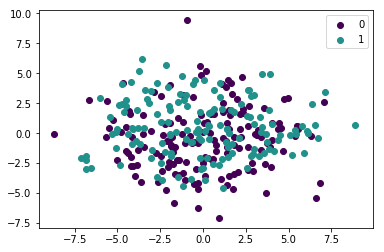

Epoch Loss : 0.04398889094591141
Variance Explained : 0.29020026326179504


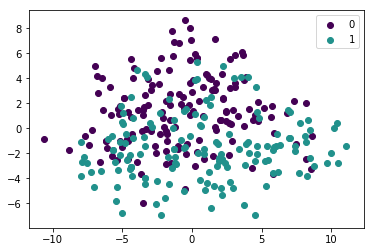

Epoch Loss : 0.04024019677724157
Variance Explained : 0.28959447145462036


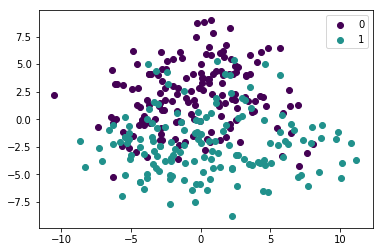

Epoch Loss : 0.03801883597459112
Variance Explained : 0.28123244643211365


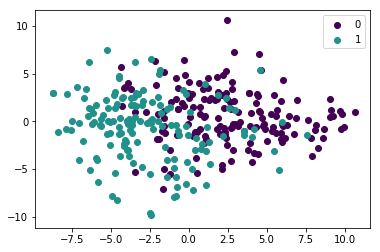

Epoch Loss : 0.038769888558558056
Variance Explained : 0.30783164501190186


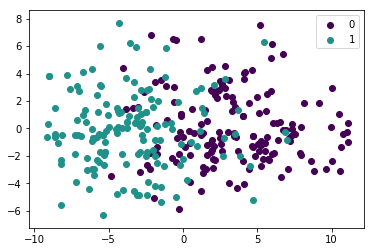

Epoch Loss : 0.034614955208131244
Variance Explained : 0.3856784701347351


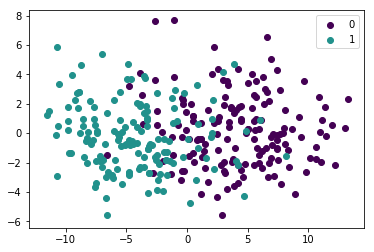

Epoch Loss : 0.03176403019045081
Variance Explained : 0.45563656091690063


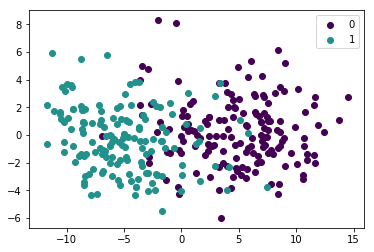

Epoch Loss : 0.02955957661781992
Variance Explained : 0.4823901951313019


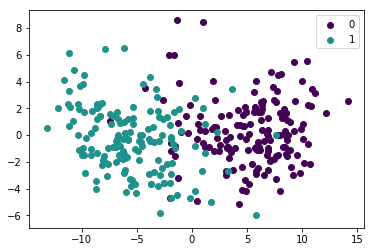

Epoch Loss : 0.026622855237552097
Variance Explained : 0.5004440546035767


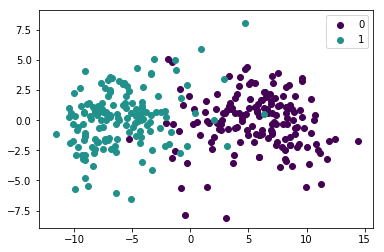

Epoch Loss : 0.0258642490953207
Variance Explained : 0.5319327712059021


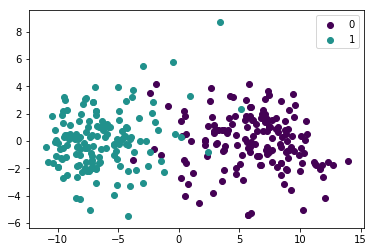

Epoch Loss : 0.02053448185324669
Variance Explained : 0.5555676221847534


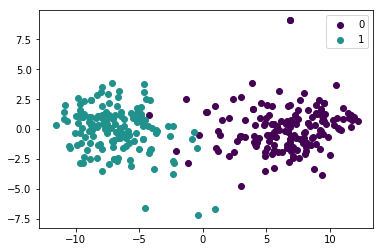

Epoch Loss : 0.016148796172014306
Variance Explained : 0.5956466197967529


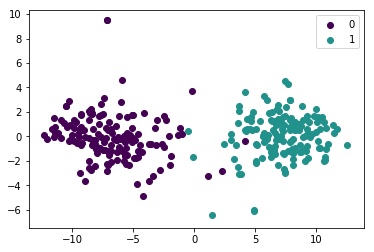

Epoch Loss : 0.013725472215030874
Variance Explained : 0.6194563508033752


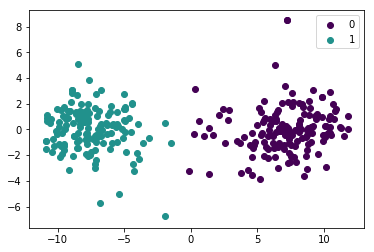

Epoch Loss : 0.0094672088245196
Variance Explained : 0.6482980847358704


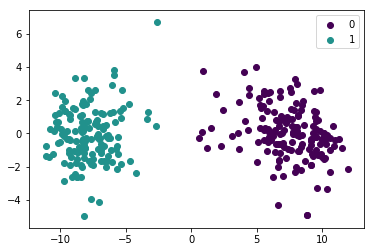

Epoch Loss : 0.00873909511470369
Variance Explained : 0.6774945259094238


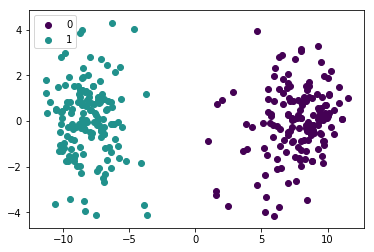

Epoch Loss : 0.006787448788860014
Variance Explained : 0.6866081357002258


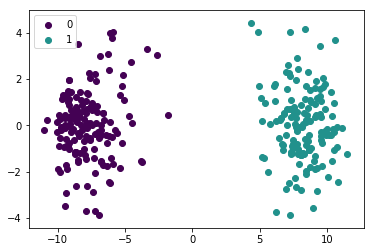

Epoch Loss : 0.005119402460487825
Variance Explained : 0.7070276737213135


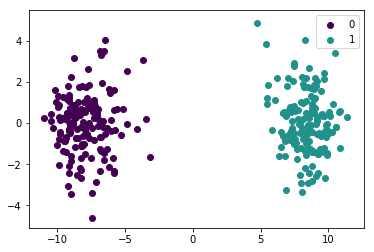

Epoch Loss : 0.005018523628158229
Variance Explained : 0.7213893532752991


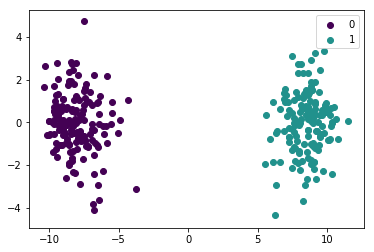

Epoch Loss : 0.004070108423807791
Variance Explained : 0.7363536357879639


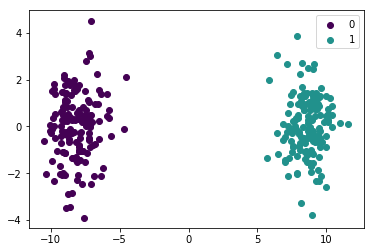

Epoch Loss : 0.003350107464939356
Variance Explained : 0.752190113067627


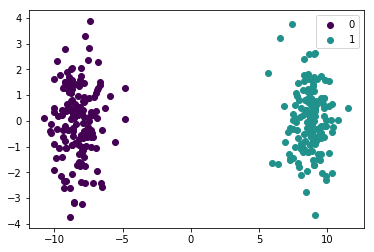

Epoch Loss : 0.002992651957486357
Variance Explained : 0.7664448618888855


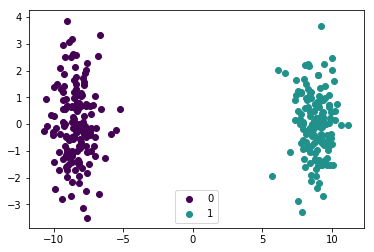

In [34]:
net.train()

for epoch in range(NUM_EPOCHS):
    epoch_loss = []
    support, labels = getSupport(net, train_dataloader_)
    getDistribution(support, labels)
    plt.show()

    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
 
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()

        epoch_loss.append(loss_contrastive.item())


    print(f"Epoch Loss : {np.mean(epoch_loss)}")


support, labels = getSupport(net, train_dataloader_)
getDistribution(support, labels)
plt.show()

In [35]:
testAcc = testModel(net,trainImgList, trainLabelList, testDataset_)
# trainAcc = testModel_(net,trainImgList, trainLabelList)

print(f" Test Acc : {testAcc}")

100%|██████████| 110/110 [00:38<00:00,  2.88it/s]

              precision    recall  f1-score   support

     class 0       0.78      0.89      0.83        53
     class 1       0.88      0.77      0.82        57

   micro avg       0.83      0.83      0.83       110
   macro avg       0.83      0.83      0.83       110
weighted avg       0.83      0.83      0.83       110

 Test Acc : 0.8273


In [35]:
print("torch版本号:",end="")
print(torch.__version__)
print("判断torch是否可用:",end="")
print(torch.cuda.is_available())
 
print("gpu数量:",end="")
print(torch.cuda.device_count())
 
print("gpu名字，设备索引默认从0开始:",end="")
print(torch.cuda.get_device_name(0))
print("现在正在使用的GPU编号:",end="")
print(torch.cuda.current_device())


torch版本号:1.9.0+cu102
判断torch是否可用:True
gpu数量:1
gpu名字，设备索引默认从0开始:Tesla T4
现在正在使用的GPU编号:0


第一次
weighted avg       0.83      0.83      0.83       110

 Test Acc : 0.8273

第二次
weighted avg       0.85      0.85      0.85       110

 Test Acc : 0.8545
 
第三次
weighted avg       0.87      0.87      0.87       110

 Test Acc : 0.8727
 
第四次

weighted avg       0.88      0.88      0.88       110

 Test Acc : 0.8818
 
第五次

weighted avg       0.83      0.83      0.83       110

 Test Acc : 0.8273

accuracy = 0.852
precision = 0.852
recall = 0.852
f1=0.852